# Import Libraries

In [ ]:
!pip install kmodes
!pip install gower scipy fastcluster --quiet
!pip install --upgrade scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-linux_x86_64.whl size=2177963 sha256=bff1a25f7beac0bcffdbb3ac3c1f657649b52afb4d7d345235aac83222c797b2
  Stored in directory: /root/.cache/pip/wheels/17/4d/c3/c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
Successfully built scikit-learn-extra


In [ ]:
import pandas as pd
import numpy as np
import gdown
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, adjusted_rand_score
import gower
import random
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import OrdinalEncoder
import math

# Load the Data


In [ ]:
def read_drive_csv(file_id, file_path, encoding='utf-8'):
    """
    Downloads a CSV file from Google Drive and reads it into a pandas DataFrame.

    Args:
        file_id (str): The Google Drive file ID.
        file_path (str): The local path to save the downloaded file.
        encoding (str, optional): The encoding to use when reading the CSV.
                                   Defaults to 'utf-8'.

    Returns:
        pandas.DataFrame: The DataFrame containing the data from the CSV file.
                          Returns None if the file could not be downloaded or read.
    """
    try:
        gdown.download(f'https://drive.google.com/uc?id={file_id}', file_path, quiet=False)
    except Exception as e:
        print(f"Error downloading file: {e}")
        return None

    try:
        df = pd.read_csv(file_path, encoding=encoding)
        return df
    except UnicodeDecodeError:
        print(f"Could not decode the file using {encoding} encoding. Trying latin1...")
        try:
            df = pd.read_csv(file_path, encoding='latin1')
            return df
        except UnicodeDecodeError:
            print("Could not decode the file using latin1. Trying cp1252...")
            try:
                df = pd.read_csv(file_path, encoding='cp1252')
                return df
            except UnicodeDecodeError:
                print("Could not decode the file using latin1 or cp1252 encoding. Please try another encoding or use a library like 'chardet' to detect the encoding.")
                return None
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

In [ ]:
# Extract file IDs from the links
file_ids = [
    '1dg504HG-xL4H7L1YpRwEcs15ZYn7erxM',   # BrandHealth
    '1wU-8kU3pktVUloLYWhS3d-qY1F_0nIeX',   # 2017Segmentation3685case
    '1f-PEt3lDnOaZ-zaT7HERzwKtheAlGanV',   # Segmentation_Lookup
    '1VjvawtC8lqk93eHjDByNgeOCr5F7ydag',   # Respondents
    '1dXmpY5o8QomOoGyTTBh7sOeTyUdL3jn7',   # City
    '16SCs69MG5zqjnO_9vGVVBlFoouTKeqhB',   # NeedStateDayPart (new)
    '18_eynnAL_H8kffmPAqC4VgPnu-3aHY6J',   # Companion (new)
    '17j_-xVQMBK7mvKsN7RGoWfJ6leqilYWD',   # DayOfWeek (new)
    '1-yrah3BHU73CnjUunXpuDr5QIVxi3dJG'    # DayPart (new)
]

# Define file paths for the downloaded files
file_paths = [
    'BrandHealth.csv',
    '2017Segmentation3685case.csv',
    'Segmentation_Lookup.csv',
    'Respondents.csv',
    'City.csv',
    'NeedStateDayPart.csv',  # Added new dataset
    'Companion.csv',         # Added new dataset
    'DayOfWeek.csv',         # Added new dataset
    'DayPart.csv'            # Added new dataset
]

# Read each file into a DataFrame
print(f"Reading {file_paths[0]}...")
df_brand_health = read_drive_csv(file_ids[0], file_paths[0])

print(f"\nReading {file_paths[1]}...")
df_2017Segmentation3685case = read_drive_csv(file_ids[1], file_paths[1])

print(f"\nReading {file_paths[2]}...")
df_Segmentation_Lookup = read_drive_csv(file_ids[2], file_paths[2])

print(f"\nReading {file_paths[3]}...")
df_Respondents = read_drive_csv(file_ids[3], file_paths[3])

print(f"\nReading {file_paths[4]}...")
df_city = read_drive_csv(file_ids[4], file_paths[4])

print(f"\nReading {file_paths[5]}...")  # New dataset
df_needstate_daypart = read_drive_csv(file_ids[5], file_paths[5])

print(f"\nReading {file_paths[6]}...")  # New dataset
df_companion = read_drive_csv(file_ids[6], file_paths[6])

print(f"\nReading {file_paths[7]}...") # New dataset
df_day_of_week = read_drive_csv(file_ids[7], file_paths[7])

print(f"\nReading {file_paths[8]}...") # New dataset
df_day_part = read_drive_csv(file_ids[8], file_paths[8])


# Drop unnamed columns from df_Respondents and df_needstate_daypart
if df_Respondents is not None:
    df_Respondents = df_Respondents.loc[:, ~df_Respondents.columns.str.contains('^Unnamed')]
if df_needstate_daypart is not None:
    df_needstate_daypart = df_needstate_daypart.loc[:, ~df_needstate_daypart.columns.str.contains('^Unnamed')]
if df_day_of_week is not None:
    df_day_of_week = df_day_of_week.loc[:, ~df_day_of_week.columns.str.contains('^Unnamed')]
if df_day_part is not None:
    df_day_part = df_day_part.loc[:, ~df_day_part.columns.str.contains('^Unnamed')]


# Display the first few rows of each DataFrame to confirm they were read correctly
if df_brand_health is not None:
    print("\nBrand Health Data:")
    display(df_brand_health.head())

if df_2017Segmentation3685case is not None:
    print("\n2017Segmentation3685case Data:")
    display(df_2017Segmentation3685case.head())

if df_Segmentation_Lookup is not None:
    print("\nSegmentation_Lookup Data:")
    display(df_Segmentation_Lookup.head())

if df_Respondents is not None:
    print("\nRespondents Data:")
    display(df_Respondents.head())

if df_city is not None:
    print("\nCity Data:")
    display(df_city.head())

if df_needstate_daypart is not None:
    print("\nNeedStateDayPart Data:")
    display(df_needstate_daypart.head())

if df_companion is not None:
    print("\nCompanion Data:")
    display(df_companion.head())

if df_day_of_week is not None:
    print("\nDayOfWeek Data:")
    display(df_day_of_week.head())

if df_day_part is not None:
    print("\nDayPart Data:")
    display(df_day_part.head())

Reading BrandHealth.csv...


Downloading...
From: https://drive.google.com/uc?id=1dg504HG-xL4H7L1YpRwEcs15ZYn7erxM
To: /content/BrandHealth.csv
100%|██████████| 7.52M/7.52M [00:00<00:00, 85.0MB/s]


Could not decode the file using utf-8 encoding. Trying latin1...

Reading 2017Segmentation3685case.csv...


Downloading...
From: https://drive.google.com/uc?id=1wU-8kU3pktVUloLYWhS3d-qY1F_0nIeX
To: /content/2017Segmentation3685case.csv
100%|██████████| 456k/456k [00:00<00:00, 28.9MB/s]



Reading Segmentation_Lookup.csv...


Downloading...
From: https://drive.google.com/uc?id=1f-PEt3lDnOaZ-zaT7HERzwKtheAlGanV
To: /content/Segmentation_Lookup.csv
100%|██████████| 226/226 [00:00<00:00, 629kB/s]



Reading Respondents.csv...


Downloading...
From: https://drive.google.com/uc?id=1VjvawtC8lqk93eHjDByNgeOCr5F7ydag
To: /content/Respondents.csv
100%|██████████| 1.78M/1.78M [00:00<00:00, 46.3MB/s]


Could not decode the file using utf-8 encoding. Trying latin1...

Reading City.csv...


Downloading...
From: https://drive.google.com/uc?id=1dXmpY5o8QomOoGyTTBh7sOeTyUdL3jn7
To: /content/City.csv
100%|██████████| 97.0/97.0 [00:00<00:00, 244kB/s]


Could not decode the file using utf-8 encoding. Trying latin1...

Reading NeedStateDayPart.csv...


Downloading...
From: https://drive.google.com/uc?id=16SCs69MG5zqjnO_9vGVVBlFoouTKeqhB
To: /content/NeedStateDayPart.csv
100%|██████████| 5.79M/5.79M [00:00<00:00, 65.9MB/s]



Reading Companion.csv...


Downloading...
From: https://drive.google.com/uc?id=18_eynnAL_H8kffmPAqC4VgPnu-3aHY6J
To: /content/Companion.csv
100%|██████████| 1.13M/1.13M [00:00<00:00, 25.0MB/s]



Reading DayOfWeek.csv...


Downloading...
From: https://drive.google.com/uc?id=17j_-xVQMBK7mvKsN7RGoWfJ6leqilYWD
To: /content/DayOfWeek.csv
100%|██████████| 1.50M/1.50M [00:00<00:00, 62.2MB/s]



Reading DayPart.csv...


Downloading...
From: https://drive.google.com/uc?id=1-yrah3BHU73CnjUunXpuDr5QIVxi3dJG
To: /content/DayPart.csv
100%|██████████| 1.34M/1.34M [00:00<00:00, 61.3MB/s]


Brand Health Data:


,BrandHealthKey,RespondentID,Year,CityID,Brand,Segmentation,Is_Spontaneous_Aware,Is_Aware,Is_Trial,Has_Brand_Likability,Comprehension,Used_P3M,Used_P1M,Frequency_Visits,PPA,Spending,NPS_Score,NPS_Group,dwh_create_date
0,1,89100,2017,2,The Coffee Factory,NaN,0,1,0,0,Did not answer,0,0,0.0,NaN,NaN,NaN,NaN,9/20/2025 14:42
1,2,89100,2017,2,Gong Cha,NaN,0,1,0,0,Did not answer,0,0,0.0,NaN,NaN,NaN,NaN,9/20/2025 14:42
2,3,89100,2017,2,Trung Nguyên,NaN,0,1,1,0,Did not answer,1,1,2.0,NaN,NaN,8.0,Passive,9/20/2025 14:42
3,4,89100,2017,2,Street Coffee,NaN,0,1,1,0,Did not answer,1,1,6.0,NaN,NaN,NaN,NaN,9/20/2025 14:42
4,5,89100,2017,2,Independent Cafe,NaN,1,1,1,0,Did not answer,1,1,4.0,NaN,NaN,NaN,NaN,9/20/2025 14:42



2017Segmentation3685case Data:


,2017SegmentationCaseKey,RespondentID,SegmentCode,CustomerType,SpendingRange,Visit,Spending,BrandType,PPA,dwh_create_date
0,1,89100,Seg.04,Super Premium,100000+,4,400000,Independent,100000,2025-09-20 14:28:49.383000000
1,2,89100,Seg.03,Premium,60000 - 99000,2,120000,Chain,60000,2025-09-20 14:28:49.383000000
2,3,89100,Seg.01,Mass,0 - 25000,6,90000,Street,15000,2025-09-20 14:28:49.383000000
3,4,89101,Seg.01,Mass,0 - 25000,1,10000,Street,10000,2025-09-20 14:28:49.383000000
4,5,89101,Seg.02,Mass Asp,25000 - 59000,2,60000,Chain,30000,2025-09-20 14:28:49.383000000



Segmentation_Lookup Data:


,SegmentCode,SegmentName,SpendingRange,MinSpending,MaxSpending
0,Seg.01,Mass,<VND 25K,0,24999.0
1,Seg.02,Mass Asp,VND 25K - VND 59K,25000,59000.0
2,Seg.03,Premium,VND 60K - VND 99K,60000,99000.0
3,Seg.04,Super Premium,VND 100K+,100000,NaN



Respondents Data:


,RespondentKey,RespondentID,CityID,GroupSize,Age,Gender,TopOfMind,BrandUseMostOften,BrandUseMostOften_Previous,MostFavourite,AgeGroup,MPI,Occupation,OccupationGroup,Year,MPI_Mean_Use
0,1,89100,2,4,39,Female,Independent Cafe,Street Coffee,Independent Cafe,Independent Cafe,35 - 39,NaN,Small Business (small shop owner,Self Employed - Small Business and Freelance,2017,NaN
1,2,89101,2,4,33,Female,Independent Cafe,Saigon Café,Effoc,Saigon Café,30 - 34,NaN,Housewife,None Working,2017,NaN
2,3,89102,2,4,17,Male,Highlands Coffee,Highlands Coffee,The Coffee House,Highlands Coffee,16 - 19,NaN,Pupil / Student,None Working,2017,NaN
3,4,89613,2,3,55,Male,Trung Nguyên,Trung Nguyên,Don't have any brands,Trung Nguyên,45+,NaN,Lecturer / Teacher,White Collar,2017,NaN
4,5,89616,2,2,60,Male,Trung Nguyên,Trung Nguyên,Don't have any brands,Trung Nguyên,45+,NaN,Small Business (small shop owner,Self Employed - Small Business and Freelance,2017,NaN



City Data:


,CityID,CityName
0,3,Câ?n Th?
1,5,?a? N??ng
2,1,Ha? Nô?i
3,4,H?i Phòng
4,2,Hô? Chi? Minh



NeedStateDayPart Data:


,NeedstateDayDaypartKey,RespondentID,CityID,Year,Needstates,DowDayPart,NeedstateGroup
0,1,89100,2,2017,Drinking coffee,Overall,Drinking beverages
1,2,89100,2,2017,Socialzing,Overall,Socializing
2,3,89100,2,2017,Enterntainment (watching movies. Playing games,Overall,Relaxing & entertainment
3,4,89100,2,2017,Drinking tea,Overall,Drinking beverages
4,5,89100,2,2017,Drinking ice-blended,Overall,Drinking beverages



Companion Data:


,CompanionKey,RespondentID,CompanionGroup,dwh_create_date
0,1,89100,Friends,2025-09-14 10:55:31.923000000
1,2,89100,Boyfriend / Girlfriend,2025-09-14 10:55:31.923000000
2,3,89101,Family,2025-09-14 10:55:31.923000000
3,4,89101,Friends,2025-09-14 10:55:31.923000000
4,5,89102,Friends,2025-09-14 10:55:31.923000000



DayOfWeek Data:


,DayOfWeekKey,RespondentID,CityID,DayOfWeek,VisitFreq,Year,WeekdayEnd,dwh_create_date
0,1,89100,2,Sunday,4.0,2017,weekends,00:45.2
1,2,89100,2,Monday,2.0,2017,weekdays,00:45.2
2,3,89100,2,Thursday,2.0,2017,weekdays,00:45.2
3,4,89100,2,Friday,2.0,2017,weekdays,00:45.2
4,5,89100,2,Saturday,2.0,2017,weekends,00:45.2



DayPart Data:


,DayPartKey,RespondentID,CityID,DayPart,VisitFreq,Year,dwh_create_date
0,1,89100,2,2 PM - before 5 PM,2.0,2017,2025-09-19 16:08:15.290000000
1,2,89100,2,11 AM - before 2 PM,2.0,2017,2025-09-19 16:08:15.290000000
2,3,89100,2,9 PM or later,4.0,2017,2025-09-19 16:08:15.290000000
3,4,89100,2,5 PM - before 9 PM,4.0,2017,2025-09-19 16:08:15.290000000
4,5,89101,2,5 PM - before 9 PM,1.0,2017,2025-09-19 16:08:15.290000000


In [ ]:
# Define a dictionary to map the incorrect city names to the correct ones
city_name_mapping = {
    'Câ?n Th?': 'Cần Thơ',
    '?a? N??ng': 'Đà Nẵng',
    'Ha? Nô?i': 'Hà Nội',
    'H?i Phòng': 'Hải Phòng',
    'Hô? Chi? Minh': 'Hồ Chí Minh',
    'Nha Trang': 'Nha Trang' # Assuming Nha Trang is correct
}

# Replace the incorrect city names in the 'CityName' column
df_city['CityName'] = df_city['CityName'].replace(city_name_mapping)

# Display the updated DataFrame to confirm the changes
print("Updated City Data:")
display(df_city.head())

Updated City Data:


,CityID,CityName
0,3,Cần Thơ
1,5,Đà Nẵng
2,1,Hà Nội
3,4,Hải Phòng
4,2,Hồ Chí Minh


In [ ]:
df_day_of_week.dropna(inplace=True)
df_brand_health.dropna(inplace=True)

In [ ]:
df_day_of_week.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31410 entries, 0 to 31535
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DayOfWeekKey     31410 non-null  int64  
 1   RespondentID     31410 non-null  int64  
 2   CityID           31410 non-null  int64  
 3   DayOfWeek        31410 non-null  object 
 4   VisitFreq        31410 non-null  float64
 5   Year             31410 non-null  int64  
 6   WeekdayEnd       31410 non-null  object 
 7   dwh_create_date  31410 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 2.2+ MB


# Feature Engineering

## 2017 Data

In [ ]:
# Isolate 2017 Respondents from df_Respondents
respondent_df_2017 = df_Respondents[df_Respondents['Year'] == 2017].copy()

# Merge the dataframes using 'RespondentID' as the common key
df_2017 = pd.merge(df_2017Segmentation3685case, respondent_df_2017, on='RespondentID', how='inner', suffixes=('_seg', '_resp'))

# Merge df_2017 with df_Segmentation_Lookup on 'SegmentCode'
df_2017 = pd.merge(df_2017, df_Segmentation_Lookup, on='SegmentCode', how='left')

# Merge df_2017 with df_needstate_daypart on 'RespondentID' and 'Year'
df_2017 = pd.merge(df_2017, df_needstate_daypart[df_needstate_daypart['Year'] == 2017], on=['RespondentID', 'Year'], how='left', suffixes=('_need', '_needstate'))

# Merge df_2017 with df_companion on 'RespondentID'
df_2017 = pd.merge(df_2017, df_companion, on='RespondentID', how='left', suffixes=('_need', '_comp'))

# Merge df_2017 with df_day_of_week on 'RespondentID' and 'Year'
df_2017 = pd.merge(df_2017, df_day_of_week[df_day_of_week['Year'] == 2017], on=['RespondentID', 'Year'], how='left', suffixes=('_comp', '_dayofweek'))

# Merge df_2017 with df_day_part on 'RespondentID' and 'Year'
df_2017 = pd.merge(df_2017, df_day_part[df_day_part['Year'] == 2017], on=['RespondentID', 'Year'], how='left', suffixes=('_dayofweek', '_daypart'))


# Display the first few rows of the updated df_2017
print("\n2017 Snapshot with Spending Ranges, City Names, Need States, Companions, Day of Week, and Day Part:")
display(df_2017.head())


2017 Snapshot with Spending Ranges, City Names, Need States, Companions, Day of Week, and Day Part:


,2017SegmentationCaseKey,RespondentID,SegmentCode,CustomerType,SpendingRange_x,Visit,Spending,BrandType,PPA,dwh_create_date_need,...,CityID_dayofweek,DayOfWeek,VisitFreq_dayofweek,WeekdayEnd,dwh_create_date_dayofweek,DayPartKey,CityID_daypart,DayPart,VisitFreq_daypart,dwh_create_date_daypart
0,1,89100,Seg.04,Super Premium,100000+,4,400000,Independent,100000,2025-09-20 14:28:49.383000000,...,2.0,Sunday,4.0,weekends,00:45.2,1,2,2 PM - before 5 PM,2.0,2025-09-19 16:08:15.290000000
1,1,89100,Seg.04,Super Premium,100000+,4,400000,Independent,100000,2025-09-20 14:28:49.383000000,...,2.0,Sunday,4.0,weekends,00:45.2,2,2,11 AM - before 2 PM,2.0,2025-09-19 16:08:15.290000000
2,1,89100,Seg.04,Super Premium,100000+,4,400000,Independent,100000,2025-09-20 14:28:49.383000000,...,2.0,Sunday,4.0,weekends,00:45.2,3,2,9 PM or later,4.0,2025-09-19 16:08:15.290000000
3,1,89100,Seg.04,Super Premium,100000+,4,400000,Independent,100000,2025-09-20 14:28:49.383000000,...,2.0,Sunday,4.0,weekends,00:45.2,4,2,5 PM - before 9 PM,4.0,2025-09-19 16:08:15.290000000
4,1,89100,Seg.04,Super Premium,100000+,4,400000,Independent,100000,2025-09-20 14:28:49.383000000,...,2.0,Monday,2.0,weekdays,00:45.2,1,2,2 PM - before 5 PM,2.0,2025-09-19 16:08:15.290000000


In [ ]:
df_2017.columns

Index(['2017SegmentationCaseKey', 'RespondentID', 'SegmentCode',
       'CustomerType', 'SpendingRange_x', 'Visit', 'Spending', 'BrandType',
       'PPA', 'dwh_create_date_need', 'RespondentKey', 'CityID_need',
       'GroupSize', 'Age', 'Gender', 'TopOfMind', 'BrandUseMostOften',
       'BrandUseMostOften_Previous', 'MostFavourite', 'AgeGroup', 'MPI',
       'Occupation', 'OccupationGroup', 'Year', 'MPI_Mean_Use', 'SegmentName',
       'SpendingRange_y', 'MinSpending', 'MaxSpending',
       'NeedstateDayDaypartKey', 'CityID_needstate', 'Needstates',
       'DowDayPart', 'NeedstateGroup', 'CompanionKey', 'CompanionGroup',
       'dwh_create_date_comp', 'DayOfWeekKey', 'CityID_dayofweek', 'DayOfWeek',
       'VisitFreq_dayofweek', 'WeekdayEnd', 'dwh_create_date_dayofweek',
       'DayPartKey', 'CityID_daypart', 'DayPart', 'VisitFreq_daypart',
       'dwh_create_date_daypart'],
      dtype='object')

In [ ]:
# Define the list of columns to drop
columns_to_drop = [
    '2017SegmentationCaseKey',
    'Visit',
    'RespondentKey',
    'NeedstateDayDaypartKey',
    'CompanionKey',
    'DayPartKey',
    'SegmentCode',
    'SegmentName',
    'CustomerType',
    'SpendingRange_y',
    'MinSpending',
    'MaxSpending',
    'PPA',
    'AgeGroup',
    'OccupationGroup',
    'WeekdayEnd',
    'VisitFreq_daypart',
    'dwh_create_date_need',
    'dwh_create_date_comp',
    'dwh_create_create_date_dayofweek', # Corrected typo
    'dwh_create_date_daypart',
    'dwh_create_date_dayofweek',
    'CityID_needstate',
    'CityID_dayofweek',
    'CityID_daypart',
    'MPI',
    'MPI_Mean_Use',
    'DowDayPart',
    'Year',
    # Additional columns from previous list that might still be present
    'BrandType',
    'TopOfMind',
    'BrandUseMostOften',
    'BrandUseMostOften_Previous',
    'MostFavourite',
    'Needstates'
]

# Create a copy of the DataFrame to avoid modifying the original
df_2017_clustering = df_2017.copy()

# Drop the specified columns
df_2017_clustering = df_2017_clustering.drop(columns=columns_to_drop, errors='ignore')

# Display the columns remaining in the DataFrame
print("Columns remaining in df_2017_clustering:")
display(df_2017_clustering.columns)
display(df_2017_clustering.head(10))

Columns remaining in df_2017_clustering:


Index(['RespondentID', 'SpendingRange_x', 'Spending', 'CityID_need',
       'GroupSize', 'Age', 'Gender', 'Occupation', 'NeedstateGroup',
       'CompanionGroup', 'DayOfWeekKey', 'DayOfWeek', 'VisitFreq_dayofweek',
       'DayPart'],
      dtype='object')

,RespondentID,SpendingRange_x,Spending,CityID_need,GroupSize,Age,Gender,Occupation,NeedstateGroup,CompanionGroup,DayOfWeekKey,DayOfWeek,VisitFreq_dayofweek,DayPart
0,89100,100000+,400000,2,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,1.0,Sunday,4.0,2 PM - before 5 PM
1,89100,100000+,400000,2,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,1.0,Sunday,4.0,11 AM - before 2 PM
2,89100,100000+,400000,2,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,1.0,Sunday,4.0,9 PM or later
3,89100,100000+,400000,2,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,1.0,Sunday,4.0,5 PM - before 9 PM
4,89100,100000+,400000,2,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,2.0,Monday,2.0,2 PM - before 5 PM
5,89100,100000+,400000,2,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,2.0,Monday,2.0,11 AM - before 2 PM
6,89100,100000+,400000,2,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,2.0,Monday,2.0,9 PM or later
7,89100,100000+,400000,2,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,2.0,Monday,2.0,5 PM - before 9 PM
8,89100,100000+,400000,2,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,3.0,Thursday,2.0,2 PM - before 5 PM
9,89100,100000+,400000,2,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,3.0,Thursday,2.0,11 AM - before 2 PM


In [ ]:
df_2017_clustering.columns

Index(['RespondentID', 'SpendingRange_x', 'Spending', 'CityID_need',
       'GroupSize', 'Age', 'Gender', 'Occupation', 'NeedstateGroup',
       'CompanionGroup', 'DayOfWeekKey', 'DayOfWeek', 'VisitFreq_dayofweek',
       'DayPart'],
      dtype='object')

In [ ]:
df_2017_clustering.shape

(219224, 14)

In [ ]:
df_2017_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219224 entries, 0 to 219223
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   RespondentID         219224 non-null  int64  
 1   SpendingRange_x      219224 non-null  object 
 2   Spending             219224 non-null  int64  
 3   CityID_need          219224 non-null  int64  
 4   GroupSize            219224 non-null  int64  
 5   Age                  219224 non-null  int64  
 6   Gender               219224 non-null  object 
 7   Occupation           219224 non-null  object 
 8   NeedstateGroup       219173 non-null  object 
 9   CompanionGroup       219224 non-null  object 
 10  DayOfWeekKey         200959 non-null  float64
 11  DayOfWeek            200959 non-null  object 
 12  VisitFreq_dayofweek  200959 non-null  float64
 13  DayPart              219193 non-null  object 
dtypes: float64(2), int64(5), object(7)
memory usage: 23.4+ MB


## 2018 and 2019 data

In [ ]:
# Isolate 2018 and 2019 BrandHealth data
df_brand_health_2018_2019 = df_brand_health[df_brand_health['Year'].isin([2018, 2019])].copy()

# Isolate 2018 and 2019 Respondents from df_Respondents
respondent_df_2018_2019 = df_Respondents[df_Respondents['Year'].isin([2018, 2019])].copy()

# Merge the dataframes using 'RespondentID' and 'Year' as the common keys
df_2018_2019 = pd.merge(df_brand_health_2018_2019, respondent_df_2018_2019, on=['RespondentID', 'Year', 'CityID'], how='inner', suffixes=('_brand', '_resp'))

# Merge df_2018_2019 with df_Segmentation_Lookup on 'Segment' and 'SegmentCode'
df_2018_2019 = pd.merge(df_2018_2019, df_Segmentation_Lookup, left_on='Segmentation', right_on='SegmentCode', how='left')

# Merge df_2018_2019 with df_needstate_daypart on 'RespondentID' and 'Year'
df_2018_2019 = pd.merge(df_2018_2019, df_needstate_daypart[df_needstate_daypart['Year'].isin([2018, 2019])], on=['RespondentID', 'Year', 'CityID'], how='left', suffixes=('_seg', '_needstate'))

# Merge df_2018_2019 with df_companion on 'RespondentID'
df_2018_2019 = pd.merge(df_2018_2019, df_companion, on='RespondentID', how='left', suffixes=('_need', '_comp'))

# Merge df_2018_2019 with df_day_of_week on 'RespondentID' and 'Year'
df_2018_2019 = pd.merge(df_2018_2019, df_day_of_week[df_day_of_week['Year'].isin([2018, 2019])], on=['RespondentID', 'Year', 'CityID'], how='left', suffixes=('_comp', '_dayofweek'))

# Merge df_2018_2019 with df_day_part on 'RespondentID' and 'Year'
df_2018_2019 = pd.merge(df_2018_2019, df_day_part[df_day_part['Year'].isin([2018, 2019])], on=['RespondentID', 'Year', 'CityID'], how='left', suffixes=('_dayofweek', '_daypart'))


# Display the first few rows of the updated df_2018_2019
print("\n2018 and 2019 Snapshot with Spending Ranges, City Names, Need States, Companions, Day of Week, and Day Part:")
display(df_2018_2019.head())


2018 and 2019 Snapshot with Spending Ranges, City Names, Need States, Companions, Day of Week, and Day Part:


,BrandHealthKey,RespondentID,Year,CityID,Brand,Segmentation,Is_Spontaneous_Aware,Is_Aware,Is_Trial,Has_Brand_Likability,...,dwh_create_date_comp,DayOfWeekKey,DayOfWeek,VisitFreq_dayofweek,WeekdayEnd,dwh_create_date_dayofweek,DayPartKey,DayPart,VisitFreq_daypart,dwh_create_date_daypart
0,19633,344108,2018,3,Other,Seg.03,1,1,1,0,...,2025-09-14 10:55:31.923000000,9664.0,Saturday,10.0,weekends,00:45.2,6100,Before 9 AM,40.0,2025-09-19 16:08:15.290000000
1,19633,344108,2018,3,Other,Seg.03,1,1,1,0,...,2025-09-14 10:55:31.923000000,9665.0,Monday,6.0,weekdays,00:45.2,6100,Before 9 AM,40.0,2025-09-19 16:08:15.290000000
2,19633,344108,2018,3,Other,Seg.03,1,1,1,0,...,2025-09-14 10:55:31.923000000,9666.0,Tuesday,6.0,weekdays,00:45.2,6100,Before 9 AM,40.0,2025-09-19 16:08:15.290000000
3,19633,344108,2018,3,Other,Seg.03,1,1,1,0,...,2025-09-14 10:55:31.923000000,9667.0,Wednesday,6.0,weekdays,00:45.2,6100,Before 9 AM,40.0,2025-09-19 16:08:15.290000000
4,19633,344108,2018,3,Other,Seg.03,1,1,1,0,...,2025-09-14 10:55:31.923000000,9668.0,Thursday,6.0,weekdays,00:45.2,6100,Before 9 AM,40.0,2025-09-19 16:08:15.290000000


In [ ]:
# Define the list of columns to drop
columns_to_drop = [
    'BrandHealthKey',
    'RespondentKey',
    'NeedstateDayDaypartKey',
    'Is_Spontaneous_Aware',
    'Is_Aware',
    'Is_Trial',
    'Has_Brand_Likability',
    'Brand',
    'Comprehension',
    'Used_P3M',
    'Used_P1M',
    'CompanionKey',
    'DayPartKey',
    'SegmentCode',
    'SegmentName',
    'CustomerType',
    'MinSpending',
    'MaxSpending',
    'PPA',
    'AgeGroup',
    'OccupationGroup',
    'WeekdayEnd',
    'VisitFreq_daypart',
    'dwh_create_date_need',
    'dwh_create_date_comp',
    'dwh_create_create_date_dayofweek', # Corrected typo
    'dwh_create_date_daypart',
    'dwh_create_date_dayofweek',
    'CityID_need', # Assuming CityID_x is the one to keep
    'CityID_needstate',
    'CityID_dayofweek',
    'CityID_daypart',
    'MPI',
    'MPI_Mean_Use',
    'DowDayPart',
    'Year',
    'NPS_Score',
    'NPS_Group',
    'Segmentation',
    'CompanionKey',
    'DayOfWeekKey',
    # Additional columns from previous list that might still be present
    'BrandType',
    'TopOfMind',
    'BrandUseMostOften',
    'BrandUseMostOften_Previous',
    'MostFavourite',
    'Needstates',
    'Frequency_Visits',
]

# Create a copy of the DataFrame to avoid modifying the original
df_2018_2019_clustering = df_2018_2019.copy()

# Drop the specified columns
df_2018_2019_clustering = df_2018_2019_clustering.drop(columns=columns_to_drop, errors='ignore')

# Display the columns remaining in the DataFrame
print("Columns remaining in df_2018_2019_clustering:")
display(df_2018_2019_clustering.columns)
display(df_2018_2019_clustering.head(10))

Columns remaining in df_2018_2019_clustering:


Index(['RespondentID', 'CityID', 'Spending', 'GroupSize', 'Age', 'Gender',
       'Occupation', 'SpendingRange', 'NeedstateGroup', 'CompanionGroup',
       'DayOfWeek', 'VisitFreq_dayofweek', 'DayPart'],
      dtype='object')

,RespondentID,CityID,Spending,GroupSize,Age,Gender,Occupation,SpendingRange,NeedstateGroup,CompanionGroup,DayOfWeek,VisitFreq_dayofweek,DayPart
0,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,VND 60K - VND 99K,Drinking beverages,Friends,Saturday,10.0,Before 9 AM
1,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,VND 60K - VND 99K,Drinking beverages,Friends,Monday,6.0,Before 9 AM
2,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,VND 60K - VND 99K,Drinking beverages,Friends,Tuesday,6.0,Before 9 AM
3,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,VND 60K - VND 99K,Drinking beverages,Friends,Wednesday,6.0,Before 9 AM
4,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,VND 60K - VND 99K,Drinking beverages,Friends,Thursday,6.0,Before 9 AM
5,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,VND 60K - VND 99K,Drinking beverages,Friends,Friday,6.0,Before 9 AM
6,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,VND 60K - VND 99K,Socializing,Friends,Saturday,10.0,Before 9 AM
7,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,VND 60K - VND 99K,Socializing,Friends,Monday,6.0,Before 9 AM
8,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,VND 60K - VND 99K,Socializing,Friends,Tuesday,6.0,Before 9 AM
9,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,VND 60K - VND 99K,Socializing,Friends,Wednesday,6.0,Before 9 AM


In [ ]:
# Define the mapping for SpendingRange
spending_range_mapping = {
    '<VND 25K': '0 - 25000',
    'VND 25K - VND 59K': '25000 - 59000',
    'VND 60K - VND 99K': '60000 - 99000',
    'VND 100K+': '100000+'
}

# Apply the mapping to the 'SpendingRange' column
df_2018_2019_clustering['SpendingRange'] = df_2018_2019_clustering['SpendingRange'].replace(spending_range_mapping)

# Display the updated DataFrame to confirm the changes
print("Updated df_2018_2019_clustering with simplified SpendingRange:")
display(df_2018_2019_clustering.head())

Updated df_2018_2019_clustering with simplified SpendingRange:


,RespondentID,CityID,Spending,GroupSize,Age,Gender,Occupation,SpendingRange,NeedstateGroup,CompanionGroup,DayOfWeek,VisitFreq_dayofweek,DayPart
0,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,60000 - 99000,Drinking beverages,Friends,Saturday,10.0,Before 9 AM
1,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,60000 - 99000,Drinking beverages,Friends,Monday,6.0,Before 9 AM
2,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,60000 - 99000,Drinking beverages,Friends,Tuesday,6.0,Before 9 AM
3,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,60000 - 99000,Drinking beverages,Friends,Wednesday,6.0,Before 9 AM
4,344108,3,65000.0,4,30,Male,Unskilled Labor (worker,60000 - 99000,Drinking beverages,Friends,Thursday,6.0,Before 9 AM


In [ ]:
# Append the 2018-2019 data to the 2017 data
df_all_years_clustering = pd.concat([df_2017_clustering, df_2018_2019_clustering], ignore_index=True)

print("Combined DataFrame shape:", df_all_years_clustering.shape)
display(df_all_years_clustering.head())

Combined DataFrame shape: (1633310, 16)


,RespondentID,SpendingRange_x,Spending,CityID_need,GroupSize,Age,Gender,Occupation,NeedstateGroup,CompanionGroup,DayOfWeekKey,DayOfWeek,VisitFreq_dayofweek,DayPart,CityID,SpendingRange
0,89100,100000+,400000.0,2.0,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,1.0,Sunday,4.0,2 PM - before 5 PM,NaN,NaN
1,89100,100000+,400000.0,2.0,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,1.0,Sunday,4.0,11 AM - before 2 PM,NaN,NaN
2,89100,100000+,400000.0,2.0,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,1.0,Sunday,4.0,9 PM or later,NaN,NaN
3,89100,100000+,400000.0,2.0,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,1.0,Sunday,4.0,5 PM - before 9 PM,NaN,NaN
4,89100,100000+,400000.0,2.0,4,39,Female,Small Business (small shop owner,Drinking beverages,Friends,2.0,Monday,2.0,2 PM - before 5 PM,NaN,NaN


In [ ]:
df_all_years_clustering.isnull().any()

,0
RespondentID,False
SpendingRange_x,True
Spending,False
CityID_need,True
GroupSize,False
Age,False
Gender,False
Occupation,False
NeedstateGroup,True
CompanionGroup,False


## Aggregate Data

In [ ]:
# --- Step 1: Clean missing values ---
df_new = df_all_years_clustering.copy()
df_new.shape

(1633310, 16)

In [ ]:
# --- Step 1: Clean missing values ---
df_new = df_all_years_clustering.copy()

# Fill missing values in VisitFreq_dayofweek with 0
df_new['VisitFreq_dayofweek'] = df_new['VisitFreq_dayofweek'].fillna(0)

# Handle the SpendingRange columns: consolidate them into one column
# Prioritize SpendingRange_x if it exists, otherwise use SpendingRange
df_new['SpendingRange'] = df_new['SpendingRange_x'].fillna(df_new['SpendingRange'])
df_new = df_new.drop(columns=['SpendingRange_x', 'CityID_need'], errors='ignore')

# Drop rows only if there are missing values in specific columns used for mode aggregation
cols_to_check_for_na = ['Gender', 'Occupation', 'NeedstateGroup',
                        'CompanionGroup', 'DayOfWeek', 'DayPart', 'SpendingRange', 'CityID']
df_new.dropna(subset=cols_to_check_for_na, inplace=True)


# --- Step 2: Define aggregation functions ---
def mode_func(x):
    """Return the mode (most frequent value)."""
    return x.mode().iloc[0] if not x.mode().empty else np.nan

# --- Step 3: Aggregate ---
numeric_cols_max = ['Spending', 'Age']  # keep max for these
numeric_col_mean = ['GroupSize', 'VisitFreq_dayofweek']        # use mean for these
mode_cols = ['Gender', 'Occupation', 'NeedstateGroup',
             'CompanionGroup', 'DayOfWeek', 'DayPart', 'SpendingRange', 'CityID'] # Added CityID to mode_cols

# Define aggregation dictionary
agg_dict = {col: 'max' for col in numeric_cols_max}
agg_dict.update({col: 'mean' for col in numeric_col_mean})
agg_dict.update({col: mode_func for col in mode_cols})

# Perform aggregation
df_cluster_agg = df_new.groupby('RespondentID', as_index=False).agg(agg_dict)

print("✅ Aggregation complete")
print("Original shape:", df_new.shape)
print("After aggregation:", df_cluster_agg.shape)
display(df_cluster_agg.head())

✅ Aggregation complete
Original shape: (1200311, 14)
After aggregation: (5300, 13)


,RespondentID,Spending,Age,GroupSize,VisitFreq_dayofweek,Gender,Occupation,NeedstateGroup,CompanionGroup,DayOfWeek,DayPart,SpendingRange,CityID
0,344108,260000.0,30,4.0,6.666667,Male,Unskilled Labor (worker,Drinking beverages,Friends,Friday,Before 9 AM,100000+,3.0
1,344465,175000.0,18,5.0,2.333333,Female,Pupil / Student,Relaxing & entertainment,Friends,Saturday,5 PM - before 9 PM,100000+,3.0
2,344532,36000.0,28,3.0,1.500000,Female,Skilled Labor (tailor,Relaxing & entertainment,Family,Saturday,5 PM - before 9 PM,25000 - 59000,3.0
3,344533,80000.0,28,4.0,1.500000,Male,Broker/ Service provider with no employee,Socializing,Colleagues / Business partner,Saturday,5 PM - before 9 PM,25000 - 59000,3.0
4,344534,60000.0,21,3.0,4.000000,Female,Unskilled Labor (worker,Relaxing & entertainment,Family,Saturday,5 PM - before 9 PM,60000 - 99000,3.0


In [ ]:
df_cluster_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5300 entries, 0 to 5299
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RespondentID         5300 non-null   int64  
 1   Spending             5300 non-null   float64
 2   Age                  5300 non-null   int64  
 3   GroupSize            5300 non-null   float64
 4   VisitFreq_dayofweek  5300 non-null   float64
 5   Gender               5300 non-null   object 
 6   Occupation           5300 non-null   object 
 7   NeedstateGroup       5300 non-null   object 
 8   CompanionGroup       5300 non-null   object 
 9   DayOfWeek            5300 non-null   object 
 10  DayPart              5300 non-null   object 
 11  SpendingRange        5300 non-null   object 
 12  CityID               5300 non-null   float64
dtypes: float64(4), int64(2), object(7)
memory usage: 538.4+ KB


# K- Prototype Clustering

In [ ]:
# Drop RespondentID
X_data = df_cluster_agg.drop(columns=['RespondentID'])

# Identify categorical columns
categorical_columns = X_data.select_dtypes(include=['object']).columns.tolist()
categorical_features = [X_data.columns.get_loc(col) for col in categorical_columns]

# Separate numeric and categorical
num_cols = X_data.select_dtypes(include=['number']).columns
cat_cols = categorical_columns

costs = []
sil_scores = []
K = range(2, 9)

def mixed_distance_matrix(X, num_cols, cat_cols, gamma=1.0):
    X_num = X[num_cols].to_numpy()
    X_cat = X[cat_cols].to_numpy() if len(cat_cols) > 0 else None
    n_samples = len(X)
    dist_matrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            d_num = np.linalg.norm(X_num[i] - X_num[j]) if len(num_cols) > 0 else 0
            d_cat = np.sum(X_cat[i] != X_cat[j]) if X_cat is not None else 0
            dist = d_num + gamma * d_cat
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    return dist_matrix

for k in K:
    kproto = KPrototypes(n_clusters=k, random_state=42, n_init=5, verbose=0)
    labels = kproto.fit_predict(X_data, categorical=categorical_features)
    costs.append(kproto.cost_)

    # Compute silhouette using precomputed mixed distances
    dist_matrix = mixed_distance_matrix(X_data, num_cols, cat_cols, gamma=1.0)
    sil_score = silhouette_score(dist_matrix, labels, metric='precomputed')
    sil_scores.append(sil_score)

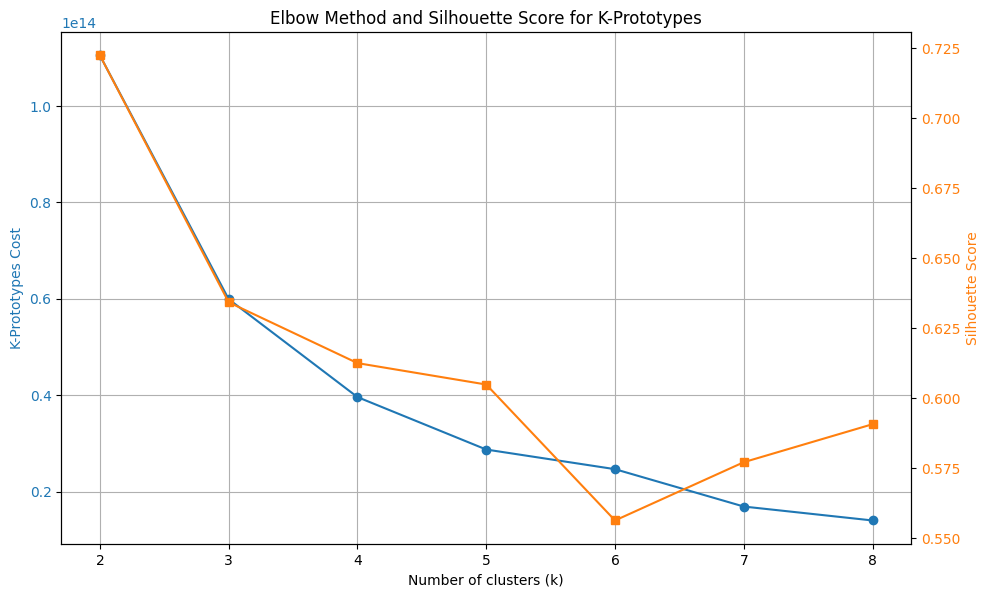

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))

color1 = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('K-Prototypes Cost', color=color1)
ax1.plot(K, costs, marker='o', color=color1, label='Elbow cost')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.plot(K, sil_scores, marker='s', color=color2, label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.title('Elbow Method and Silhouette Score for K-Prototypes')
fig.show()


In [ ]:
for gamma in [0.5, 1, 2, 5, 10]:
    kproto = KPrototypes(n_clusters=5, random_state=42, n_init=5, verbose=0, gamma=gamma)
    labels = kproto.fit_predict(X_data, categorical=categorical_features)
    print(f'Gamma={gamma}, Cost={kproto.cost_:.2f}')

Gamma=0.5, Cost=28727674761788.88
Gamma=1, Cost=28727674771528.88
Gamma=2, Cost=28727674791008.88
Gamma=5, Cost=28727674849448.88
Gamma=10, Cost=28727674946848.88


In [ ]:
# --- Step 6: Run K-Prototypes ---
kproto = KPrototypes(n_clusters=5, random_state=42, n_init=10, verbose=1)
clusters = kproto.fit_predict(X_data, categorical=categorical_features)

# --- Step 7: Add cluster labels ---
df_cluster_agg['Cluster'] = clusters

print("\n✅ K-Prototypes clustering complete!")
print(df_cluster_agg['Cluster'].value_counts())

# --- Step 8: Preview results ---
df_cluster_agg.head()

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2370, ncost: 53681671564580.055
Run: 1, iteration: 2/100, moves: 647, ncost: 46147741451446.69
Run: 1, iteration: 3/100, moves: 781, ncost: 38688135652838.84
Run: 1, iteration: 4/100, moves: 432, ncost: 36358549991573.19
Run: 1, iteration: 5/100, moves: 209, ncost: 35731223388480.29
Run: 1, iteration: 6/100, moves: 290, ncost: 34528659618497.113
Run: 1, iteration: 7/100, moves: 592, ncost: 32784707280129.59
Run: 1, iteration: 8/100, moves: 196, ncost: 32641919759106.34
Run: 1, iteration: 9/100, moves: 11, ncost: 32641190615399.375
Run: 1, iteration: 10/100, moves: 0, ncost: 32641190615399.375
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1431, ncost: 36181797360290.75
Run: 2, iteration: 2/100, moves: 585, ncost: 33937423756427.51
Run:

,RespondentID,Spending,Age,GroupSize,VisitFreq_dayofweek,Gender,Occupation,NeedstateGroup,CompanionGroup,DayOfWeek,DayPart,SpendingRange,CityID,Cluster
0,344108,260000.0,30,4.0,6.666667,Male,Unskilled Labor (worker,Drinking beverages,Friends,Friday,Before 9 AM,100000+,3.0,3
1,344465,175000.0,18,5.0,2.333333,Female,Pupil / Student,Relaxing & entertainment,Friends,Saturday,5 PM - before 9 PM,100000+,3.0,3
2,344532,36000.0,28,3.0,1.500000,Female,Skilled Labor (tailor,Relaxing & entertainment,Family,Saturday,5 PM - before 9 PM,25000 - 59000,3.0,1
3,344533,80000.0,28,4.0,1.500000,Male,Broker/ Service provider with no employee,Socializing,Colleagues / Business partner,Saturday,5 PM - before 9 PM,25000 - 59000,3.0,1
4,344534,60000.0,21,3.0,4.000000,Female,Unskilled Labor (worker,Relaxing & entertainment,Family,Saturday,5 PM - before 9 PM,60000 - 99000,3.0,1


In [ ]:
df_cluster_agg.to_csv("Clustering_result.csv")

In [ ]:
# --- Separate numeric and categorical columns ---
numeric_cols = ['Spending', 'GroupSize', 'Age', 'VisitFreq_dayofweek']
categorical_cols = ['Gender', 'Occupation', 'NeedstateGroup',
                    'CompanionGroup', 'DayOfWeek', 'DayPart', 'SpendingRange']

# --- Numeric summaries (average per cluster) ---
num_summary = df_cluster_agg.groupby('Cluster')[numeric_cols].mean().round(2)

# --- Categorical summaries (mode per cluster) ---
cat_summary = df_cluster_agg.groupby('Cluster')[categorical_cols].agg(lambda x: x.mode().iloc[0])

# --- Combine summaries ---
cluster_summary = pd.concat([num_summary, cat_summary], axis=1)

# --- Display ---
print("✅ Cluster summary created:")
display(cluster_summary)


✅ Cluster summary created:


,Spending,GroupSize,Age,VisitFreq_dayofweek,Gender,Occupation,NeedstateGroup,CompanionGroup,DayOfWeek,DayPart,SpendingRange
Cluster,,,,,,,,,,,
0,429960.00,3.36,34.60,4.30,Male,Officer - Staff level,Drinking beverages,Friends,Friday,5 PM - before 9 PM,100000+
1,84728.54,3.32,34.39,2.95,Female,Unskilled Labor (worker,Drinking beverages,Family,Saturday,5 PM - before 9 PM,100000+
2,1484659.57,3.40,33.49,4.96,Female,Officer - Staff level,Drinking beverages,Colleagues / Business partner,Friday,5 PM - before 9 PM,100000+
3,240033.27,3.35,34.43,3.87,Male,Unskilled Labor (worker,Drinking beverages,Friends,Friday,5 PM - before 9 PM,100000+
4,752463.32,3.29,34.00,5.16,Male,Officer - Staff level,Drinking beverages,Friends,Friday,5 PM - before 9 PM,100000+


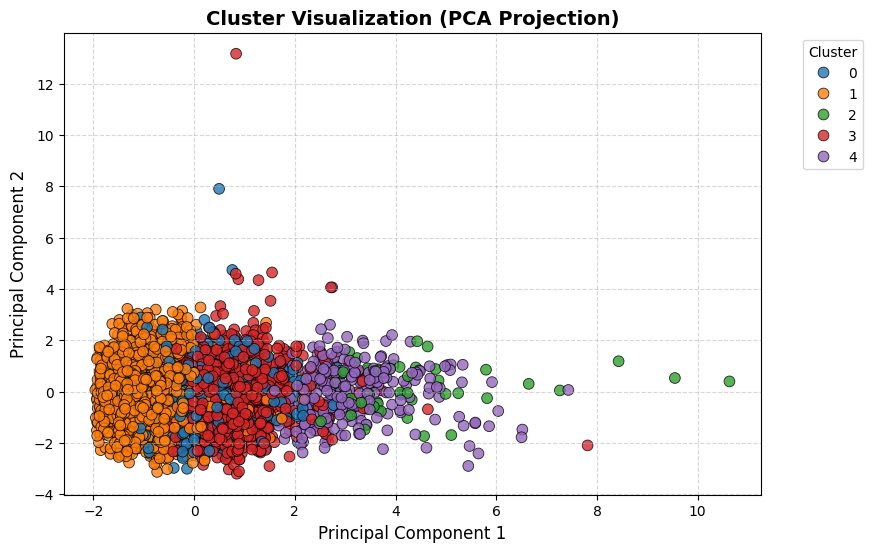

In [ ]:
# Keep only numeric columns for PCA
numeric_data = df_cluster_agg.select_dtypes(include=['number']).drop(columns=['RespondentID'], errors='ignore')
scaled = StandardScaler().fit_transform(numeric_data)

# 2D PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df_cluster_agg['Cluster']

plt.figure(figsize=(9,6))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='Cluster',
    palette='tab10',
    s=60,
    alpha=0.8,
    edgecolor='black'
)
plt.title("Cluster Visualization (PCA Projection)", fontsize=14, weight='bold')
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
# --- 3D PCA ---
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(scaled)

pca_df_3d = pd.DataFrame(pca_result_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df_3d['Cluster'] = df_cluster_agg['Cluster']

# --- Plotly 3D Scatter Plot ---
fig_3d = px.scatter_3d(
    pca_df_3d,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    title='Cluster Visualization (3D PCA Projection)',
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'}
)

fig_3d.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig_3d.show()